[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gerberlab/MDSINE2_Paper/blob/main/tutorials/tut_03_cross_validation.ipynb)
# Tutorial 3: Cross validation
In this tutorial, we'll show how to perform cross-validation by running inference using data from 3 subjects and then generating predicted trajectories in a held-out fourth subject.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Get data
    !curl -LJO https://github.com/gerberlab/MDSINE2_Paper/raw/main/datasets/gibson/tutorial_data/healthy-toy.zip
    !curl -LJO https://github.com/gibsonlab/MDSINE2_Paper/raw/main/datasets/gibson/tutorial_data/negbin_params.npz
    
    !mkdir -p ./datasets/gibson/tutorial_data/
    !unzip -o healthy-toy.zip -d ./datasets/gibson/tutorial_data/
    !mv negbin_params.npz ./datasets/gibson/tutorial_data/

    !git clone https://github.com/gerberlab/MDSINE2
    !pip install MDSINE2/.

else:
    %cd ..

/home/danmacdonald/Projects/MDSINE2_Paper


In [2]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import numpy as np 
from pathlib import Path 
import matplotlib.pyplot as plt 

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

bold = lambda x: color.BOLD + x + color.END

[DEBUG] Using default logger (stdout, stderr).


## Load data
Just as in the previous tutorial, we'll first load the toy dataset. We'll re-use the learned dispersion parameters for the measurement model, so we don't need to load the replicate data this time. 

In [3]:
data_dir = Path('./datasets/')
tut_data_dir = data_dir / 'gibson' / 'tutorial_data'
healthy_dir =  tut_data_dir / 'healthy-toy'

cv_output_dir = Path('./output/cv')
fig_dir = Path('./figs/')

cv_output_dir.mkdir(exist_ok=True, parents=True)
fig_dir.mkdir(exist_ok=True, parents=True)

# Make the data and validation Study objects
tsv_files = sorted(healthy_dir.glob('*.tsv'))
tsv_files = {f.stem : f for f in tsv_files}

# Read data into study object
study = md2.dataset.parse(
    name = healthy_dir.stem,
    metadata = tsv_files['metadata'],
    taxonomy = tsv_files['rdp_species'],
    reads = tsv_files['counts'],
    qpcr = tsv_files['qpcr'],
    perturbations = tsv_files['perturbations'],
)

[INFO] TaxaSet parsng new taxonomy table. Resetting
[INFO] No `name` found - assuming index is the name
[DEBUG] Reseting perturbations


## Remove the validation subject from the study
We'll use the `pop_subject` method of the MDSINE2 study object to remove a subject from the study. To make sure that it's removed, we'll print the subjects in each of our studies.  

In [4]:
# Remove subject 4
val_subj_id = 4
val = study.pop_subject(f'{val_subj_id}')
val.name = study.name + '-validate'

print("Study", bold(study.name), "contains subjects", [subj.name for subj in study])
print('This study contains the following perturbations: \n', *study.perturbations)

print("Study", bold(val.name), "contains subjects", [subj.name for subj in val])
print('The validation study contains the following perturbations', *val.perturbations)


Study healthy-toy contains subjects ['2', '3', '5']
This study contains the following perturbations: 
 Perturbation High Fat Diet:
	Subject 2: (21.5, 28.5)
	Subject 3: (21.5, 28.5)
	Subject 5: (21.5, 28.5)
 Perturbation Vancomycin:
	Subject 2: (35.5, 42.5)
	Subject 3: (35.5, 42.5)
	Subject 5: (35.5, 42.5)
 Perturbation Gentamicin:
	Subject 2: (50.5, 57.5)
	Subject 3: (50.5, 57.5)
	Subject 5: (50.5, 57.5)

Study healthy-toy-validate contains subjects ['4']
The validation study contains the following perturbations Perturbation High Fat Diet:
	Subject 4: (21.5, 28.5)
 Perturbation Vancomycin:
	Subject 4: (35.5, 42.5)
 Perturbation Gentamicin:
	Subject 4: (50.5, 57.5)



## Initialize parameters and run inference
We learned the negative binomial model in the previous tutorial, so we'll reuse those parameters here.

In [5]:
negbin_params = np.load(tut_data_dir / 'negbin_params.npz')
a0 = negbin_params['a0'].item()
a1 = negbin_params['a1'].item()
print(f'Reusing a0 and a1 from tutorial 2: a0 = {a0}, a1 = {a1}')

# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / study.name, 
    seed=0, 
    burnin=500, n_samples=5000, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)


Reusing a0 and a1 from tutorial 2: a0 = 1.9940356992343302e-10, a1 = 0.07167989872327986
[INFO] max_value found: 551243918704.4608, scaling_factor: 1.8140789695244354e-10
[INFO] Normalizing abundances for a max value of 100. Normalization constant: 1.8141E-10
[INFO] There are 229 qPCR measurements for 3 buckets. Each bucket is 76 measurements long
[INFO] Initializing Filtering
[INFO] Setting up the essential timepoints
[INFO] Essential timepoints: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[INFO] Initializing Zero inflation


[WARNING] `zero_inflation_transition_policy` is None so we are not doing anything


[INFO] Initializing LHS vector
[INFO] Initializing growth design matrix
[INFO] Initializing self-interactions design matrix
[INFO] Initializing Clustering concentration parameter
[INFO] Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
[INFO] Initializing Clustering parameter
[INFO] Cluster Assingments initialization results:
Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['ASV_1']
	size: 1
Cluster 100116
	members: ['ASV_2']
	size: 1
Cluster 100117
	members: ['ASV_3']
	size: 1
Cluster 100118
	members: ['ASV_4']
	size: 1
Cluster 100119
	members: ['ASV_5']
	size: 1
Cluster 100120
	members: ['ASV_6']
	size: 1
Cluster 100121
	members: ['ASV_7']
	size: 1
Cluster 100122
	members: ['ASV_8']
	size: 1
Cluster 100123
	members: ['ASV_9']
	size: 1
Cluster 100124
	members: ['ASV_10']
	size: 1
Cluster 100125
	members: ['ASV_11']
	size: 1
Cluster 100126
	members: ['ASV_12']
	size: 1
Clu

## Forward simulate
Using the model inferred from the `study` dataset, we'll generate trajectories (e.g., how microbial absolute abundance changes over time) for our held-out `val` dataset.  

`M_truth` is the ground-truth absolute abundance of the validation subject. We'll use the initial abundances of the validation dataset to initialize our trajectories, but we'll set a minimum abundance of 1e5. 

In [6]:
# Get the initial conditions
subj = val[str(val_subj_id)]
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, 
    initial_conditions=initial_conditions, 
    times=times, 
    simulation_dt=0.01
)

[INFO] 5/4500 - 0.12636089324951172
[INFO] 10/4500 - 0.12540626525878906
[INFO] 15/4500 - 0.12474846839904785
[INFO] 20/4500 - 0.1251368522644043
[INFO] 25/4500 - 0.1247243881225586
[INFO] 30/4500 - 0.1248776912689209
[INFO] 35/4500 - 0.1253194808959961
[INFO] 40/4500 - 0.12838196754455566
[INFO] 45/4500 - 0.12541723251342773
[INFO] 50/4500 - 0.1246035099029541
[INFO] 55/4500 - 0.12547659873962402
[INFO] 60/4500 - 0.12450218200683594
[INFO] 65/4500 - 0.1252601146697998
[INFO] 70/4500 - 0.12622690200805664
[INFO] 75/4500 - 0.12538719177246094
[INFO] 80/4500 - 0.12516999244689941
[INFO] 85/4500 - 0.12474942207336426
[INFO] 90/4500 - 0.12534499168395996
[INFO] 95/4500 - 0.1251523494720459
[INFO] 100/4500 - 0.12480378150939941
[INFO] 105/4500 - 0.12494778633117676
[INFO] 110/4500 - 0.12477779388427734
[INFO] 115/4500 - 0.12500858306884766
[INFO] 120/4500 - 0.12612605094909668
[INFO] 125/4500 - 0.1279771327972412
[INFO] 130/4500 - 0.12461352348327637
[INFO] 135/4500 - 0.1250467300415039
[IN

## Plot the predicted trajectory and the ground-truth trajectory
Now we'll plot the predicted trajectory ("Forward Sim") against the ground-truth abundances from the data (labelled "Data" in the plot). 

As in the previous tutorial, we emphasize that we are only using 15 taxa and a small number of samples during inference, and so these results are not representative of the results presented in the paper. 

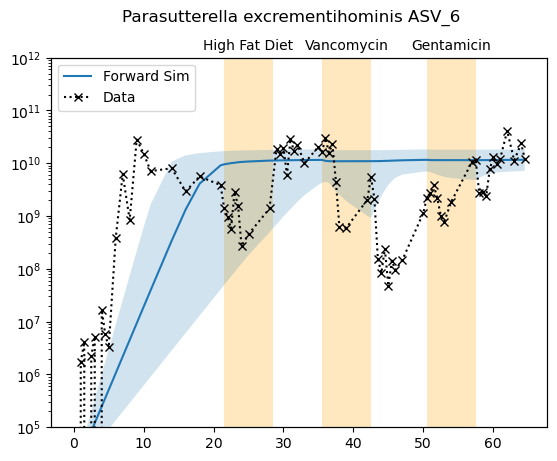

In [7]:
# Plot the forward sims, 5th-95th percentile
taxa = subj.taxa

low = np.percentile(M, q=5, axis=0)
high = np.percentile(M, q=95, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 5 # OTU 4

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.savefig(fig_dir / 'forward_sim.png')